In [1]:
%pip install pandas imblearn scikit-learn scikit-fuzzy matplotlib tensorflow numpy==1.23


  Using cached pandas-2.2.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (89 kB)
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached scikit_learn-1.5.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (13 kB)
  Using cached scikit_fuzzy-0.5.0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-macosx_10_12_x86_64.whl.metadata (11 kB)
  Using cached tensorflow-2.16.2-cp310-cp310-macosx_10_15_x86_64.whl.metadata (4.1 kB)
  Using cached numpy-1.23.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (2.2 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
  Using cached scipy-1.14.1-cp310-cp310-macosx_14_0_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached cont

# 1. Feature Dataset Exploration


## Analyze Features
 Understand the feature distribution in the dataset (e.g., EEG frequency bands, amplitude, power).
 
## Identify Ambiguities
 Check for overlapping classes or noisy features that could benefit from fuzzy handling.


In [2]:
import pandas as pd

# Load the uploaded dataset
file_path = 'extracted_normalized_features_combined.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
data.head()


,Event_Count,Task_Label,File_ID,Delta_TP9_mean,Delta_TP9_var,Delta_TP9_min,Delta_TP9_max,Delta_AF7_mean,Delta_AF7_var,Delta_AF7_min,...,Gamma_AF7_min,Gamma_AF7_max,Gamma_AF8_mean,Gamma_AF8_var,Gamma_AF8_min,Gamma_AF8_max,Gamma_TP10_mean,Gamma_TP10_var,Gamma_TP10_min,Gamma_TP10_max
0,Blink_001,Blink,file_01,0.129304,0.031033,0.154049,0.207428,0.269407,0.041775,0.224819,...,0.226347,0.272812,0.151008,0.715496,0.128783,0.401328,0.241935,0.146010,0.224916,0.440349
1,Blink_001,Blink,file_02,0.324936,0.000222,0.368120,0.307825,0.191772,0.000364,0.232022,...,0.251238,0.129079,0.230439,0.001842,0.296325,0.229381,0.124894,0.006758,0.178300,0.142193
2,Blink_001,Blink,file_03,0.242223,0.008938,0.247544,0.313026,0.342437,0.023952,0.297328,...,0.159686,0.109094,0.164076,0.026947,0.216984,0.202427,0.164592,0.011333,0.181823,0.181167
3,Blink_001,Blink,file_04,0.276507,0.000699,0.323175,0.265500,0.279803,0.012721,0.275513,...,0.213295,0.117304,0.133392,0.002068,0.207204,0.140294,0.179341,0.006629,0.202415,0.185792
4,Blink_001,Blink,file_05,0.258928,0.029744,0.215655,0.283063,0.255626,0.149554,0.077529,...,0.258459,0.316968,0.262063,0.409224,0.264849,0.420165,0.340322,0.067505,0.321532,0.459666


# Fuzzy logic implementation - steps to integrate Fuzzy Logic for Motor Imagery Classification

## Step 1: Feature Selection
- Identify key features from the dataset that contribute significantly to classification.
- Examples: `Delta_TP9_mean`, `Gamma_AF7_var`, etc.

## Step 2: Fuzzification
- Define fuzzy sets (e.g., "low," "medium," "high") for selected features.
- Use triangular or trapezoidal membership functions.

## Step 3: Integration with Classifier
- Combine the output of the fuzzy logic system with your existing classifier:
  - Use it as a preprocessing step or in an ensemble model.

## Step 4: Evaluation
- Compare the performance of the fuzzy-enhanced classifier with your original model using metrics like accuracy, precision, and recall.


----

## Step 1: Feature Selection
- Identify key features from the dataset that contribute significantly to classification.
- Examples: `Delta_TP9_mean`, `Gamma_AF7_var`, etc.


### Data Splitting and Balancing

1. **Filtering Classes**:
   - Some classes may not be relevant to the task at hand (e.g., "Jaw_Clench," "Marker_4"), and including them could add noise to the classification process.
   - Filtering out unwanted classes focuses the model on relevant categories, improving classification accuracy.

2. **Defining Features and Labels**:
   - Dropping unnecessary columns (like `File_ID` and `Event_Count`) ensures only useful features are used for classification.
   - The target label (`Task_Label`) is separated for use in training and evaluation.

3. **Data Splitting**:
   - Using `train_test_split` with `stratify=y` ensures class distribution remains consistent between training and testing sets.
   - This is critical for datasets with imbalanced classes, as it prevents overrepresentation of certain classes in one split.

4. **Balancing the Dataset**:
   - Imbalanced datasets can bias the model toward overrepresented classes, leading to poor generalization for underrepresented ones.
   - **Random Undersampling** is used to balance the training set by reducing the samples of overrepresented classes, ensuring each class has similar representation.
   - This approach avoids the model overfitting on majority classes.

5. **Balancing Testing Set**:
   - While not strictly necessary, balancing the testing set provides a fair evaluation of the model’s performance across all classes.

In [22]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# Filter out unwanted classes
classes_to_remove = ["Jaw_Clench", "Marker_4"]  # Example classes to exclude
data_filtered = data[~data["Task_Label"].isin(classes_to_remove)]

# Define features (X) and target labels (y)
X = data_filtered.drop(columns=["Task_Label", "File_ID", "Event_Count"])
y = data_filtered["Task_Label"]

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Downsampling the over-represented classes in the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Downsampling the testing set for balanced evaluation
rus_test = RandomUnderSampler(random_state=42)
X_test_resampled, y_test_resampled = rus_test.fit_resample(X_test, y_test)

# Display class distributions and dataset sizes
training_distribution = y_train_resampled.value_counts()
testing_distribution = y_test_resampled.value_counts()

training_distribution, testing_distribution, X_train_resampled.shape[0], X_test_resampled.shape[0]


(Task_Label
 Blink    54
 Left     54
 Relax    54
 Right    54
 Name: count, dtype: int64,
 Task_Label
 Blink    13
 Left     13
 Relax    13
 Right    13
 Name: count, dtype: int64,
 216,
 52)

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Train a Random Forest model to calculate feature importance
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_resampled, y_train_resampled)

# Step 2: Calculate feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Step 3: Select the top 10 features
top_features = feature_importances.head(10)['Feature'].to_list()

# Step 4: Filter the training and testing sets to include only the top features
X_train_resampled_top = X_train_resampled[top_features]
X_test_resampled_top = X_test_resampled[top_features]

# Optional: Print the selected top features
print("Top 10 selected features:")
feature_importances

Top 10 selected features:


,Feature,Importance
69,Gamma_AF7_var,0.018481
47,Alpha_TP10_max,0.018471
74,Gamma_AF8_min,0.017366
17,Theta_TP9_var,0.017173
41,Alpha_AF8_var,0.017011
...,...,...
22,Theta_AF7_min,0.009137
18,Theta_TP9_min,0.009133
38,Alpha_AF7_min,0.009087
60,Beta_TP10_mean,0.009010


# Step 2 - Fuzzification

## Objective
To define and refine fuzzy membership functions ("low," "medium," "high") for a selected feature based on its data distribution, ensuring the fuzzy sets are meaningful and capture the feature's variability.

## Steps

### 1. Analyze Feature Distribution
- Plot the histogram of the feature to observe its range and distribution.
- Identify clusters or significant regions that might influence membership boundaries.

### 2. Define Initial Membership Functions
- Use triangular or trapezoidal functions to represent fuzzy sets.
- Divide the range of the feature into three overlapping sets: "low," "medium," and "high."
  - Example:
    - "Low": Covers values near the minimum.
    - "Medium": Covers values around the middle range.
    - "High": Covers values near the maximum.

### 3. Visualize Membership Functions
- Plot the membership functions alongside the feature's distribution to evaluate their fit.

### 4. Adjust Membership Functions
- Shift or resize the fuzzy sets based on observed clusters or skewness in the distribution.
- Ensure overlapping regions between "low," "medium," and "high" to allow for smooth transitions.

### 5. Validate Adjustments
- Confirm the adjusted membership functions cover the feature's range appropriately and align with its distribution.

## Outcome
Refined fuzzy membership functions that are both mathematically valid and biologically/practically meaningful for the feature in the classification context.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Function to create and visualize fuzzy membership functions with parameterized set points
def create_membership_functions(feature_name, feature_data, fuzzy_points=None):
    # Get the range of the feature
    min_val, max_val = feature_data.min(), feature_data.max()
    range_val = max_val - min_val
    
    # Define default fuzzy set points if none are provided
    if fuzzy_points is None:
        fuzzy_points = {
            "low": [min_val, min_val, min_val + 0.3 * range_val],
            "medium": [min_val + 0.2 * range_val, min_val + 0.5 * range_val, min_val + 0.8 * range_val],
            "high": [min_val + 0.7 * range_val, max_val, max_val]
        }

    # Generate x-values for plotting
    x_vals = np.linspace(min_val, max_val, 1000)

    # Create fuzzy membership functions
    low_membership = fuzz.trimf(x_vals, fuzzy_points["low"])
    medium_membership = fuzz.trimf(x_vals, fuzzy_points["medium"])
    high_membership = fuzz.trimf(x_vals, fuzzy_points["high"])

    # Plot the membership functions
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, low_membership, label='Low', linewidth=2)
    plt.plot(x_vals, medium_membership, label='Medium', linewidth=2)
    plt.plot(x_vals, high_membership, label='High', linewidth=2)
    plt.title(f"Fuzzy Membership Functions for {feature_name}", fontsize=14)
    plt.xlabel(f"{feature_name} Value", fontsize=12)
    plt.ylabel("Membership Degree", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


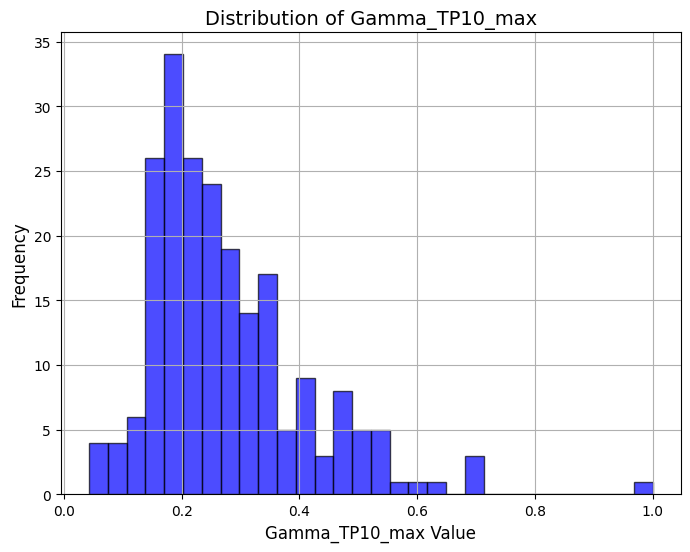

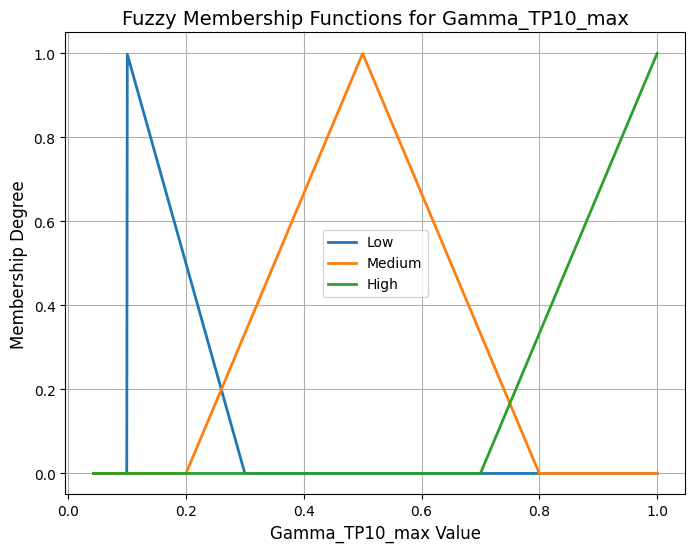

In [6]:
# Apply to the feature "Gamma_TP10_max"
feature_name = "Gamma_TP10_max"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Gamma_TP10_max 
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


# Example of using custom fuzzy points
gamma_tp10_max_fuzzy_points = {
    "low": [0.1, 0.1, 0.3],
    "medium": [0.2, 0.5, 0.8],
    "high": [0.7, 1.0, 1.0]
}
create_membership_functions(feature_name, feature_data, fuzzy_points=gamma_tp10_max_fuzzy_points)


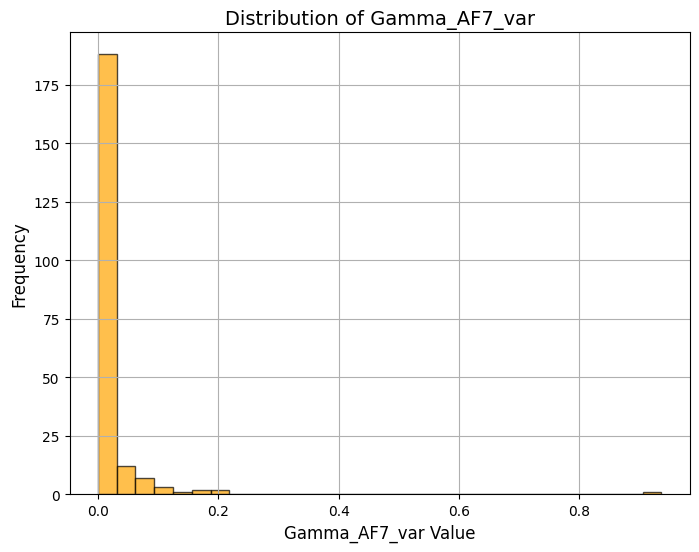

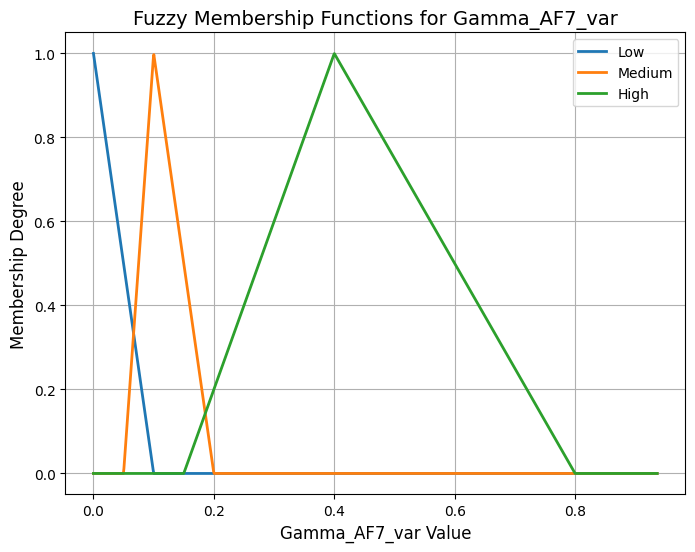

In [7]:
# Apply to the feature "Gamma_AF7_var"
feature_name = "Gamma_AF7_var"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Gamma_AF7_var to analyze
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Adjust fuzzy points for Gamma_AF7_var based on observed distribution
gamma_af7_var_fuzzy_points = {
    "low": [0.0, 0.0, 0.1],  # Strongly emphasize the dense cluster near 0.0
    "medium": [0.05, 0.1, 0.2],  # Cover the transition range
    "high": [0.15, 0.4, 0.8]  # Focus on the sparse upper range
}

# Visualize the membership functions with the adjusted fuzzy points
create_membership_functions("Gamma_AF7_var", feature_data, fuzzy_points=gamma_af7_var_fuzzy_points)


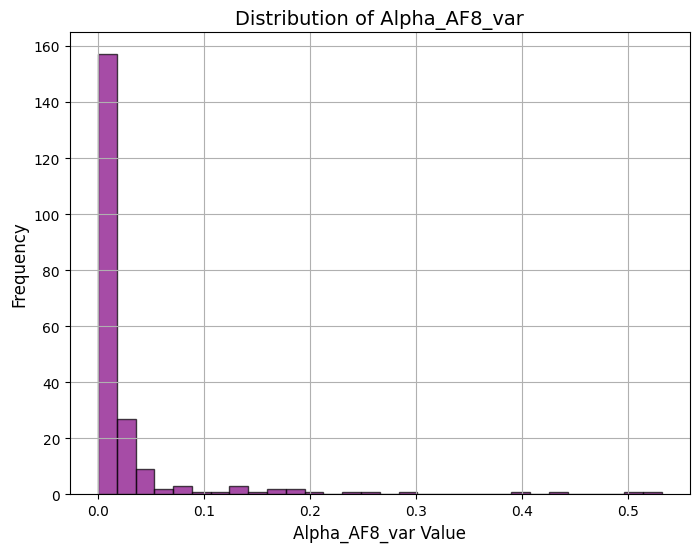

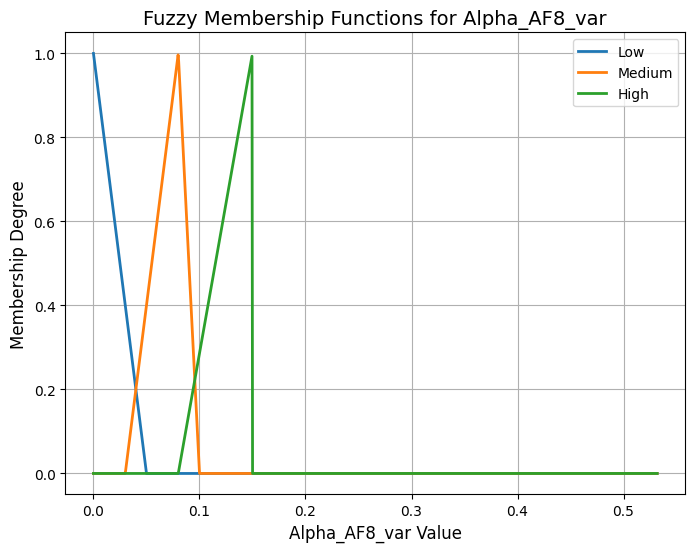

In [8]:
# Apply to the next feature "Alpha_AF8_var"
feature_name = "Alpha_AF8_var"
feature_data = X_train_resampled[feature_name]

# Analyze the distribution: Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


alpha_af8_var_fuzzy_points = {
    "low": [0.0, 0.0, 0.05],  # Emphasize the dominant cluster near 0.0
    "medium": [0.03, 0.08, 0.1],  # Span the mid-range values
    "high": [0.08, 0.15, 0.15]  # Cover the upper sparse range
}
create_membership_functions(feature_name, feature_data, fuzzy_points=alpha_af8_var_fuzzy_points)



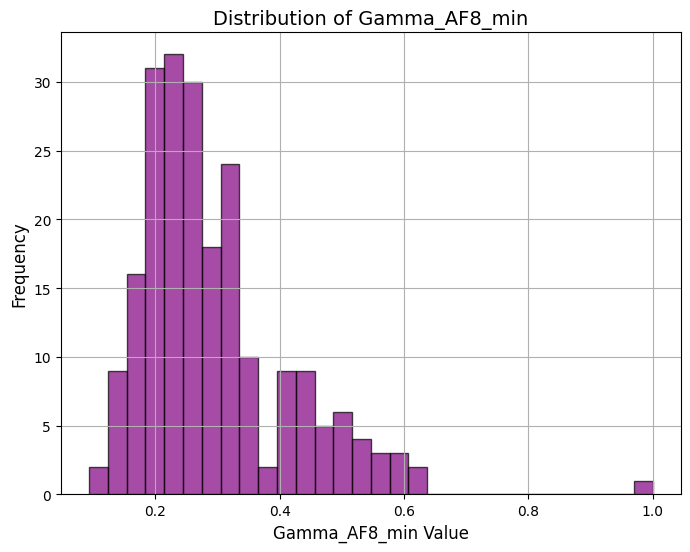

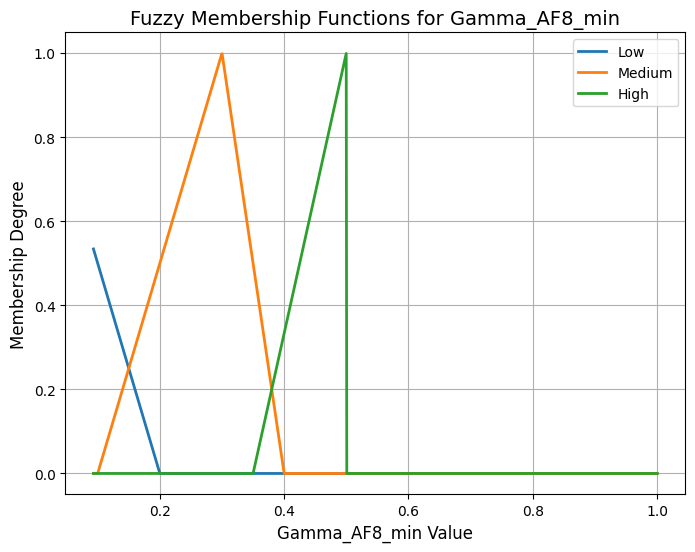

In [9]:
# Apply to the next feature "Gamma_AF8_min"
feature_name = "Gamma_AF8_min"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Gamma_AF8_min to analyze
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Define fuzzy points for Gamma_AF8_min based on observed distribution
gamma_af8_min_fuzzy_points = {
    "low": [0.0, 0.0, 0.2],  # Capture the dense cluster near 0.0
    "medium": [0.1, 0.3, 0.4],  # Cover the transition mid-range
    "high": [0.35, 0.5, 0.5]  # Emphasize the sparse upper range
}

create_membership_functions(feature_name, feature_data, fuzzy_points=gamma_af8_min_fuzzy_points)



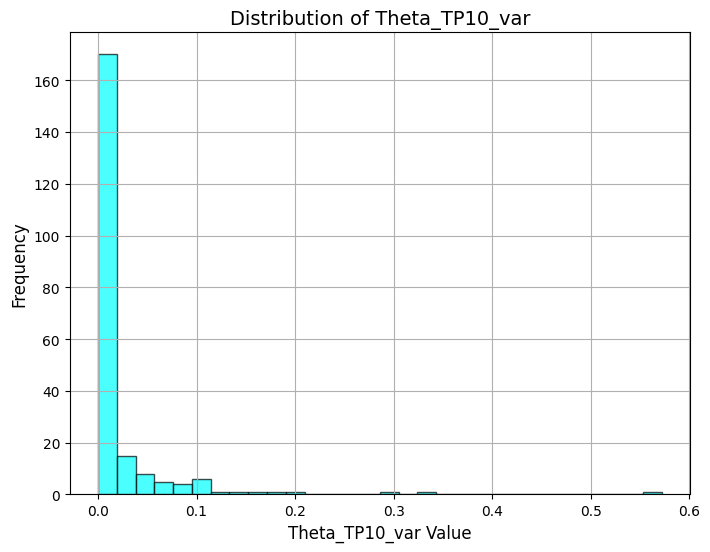

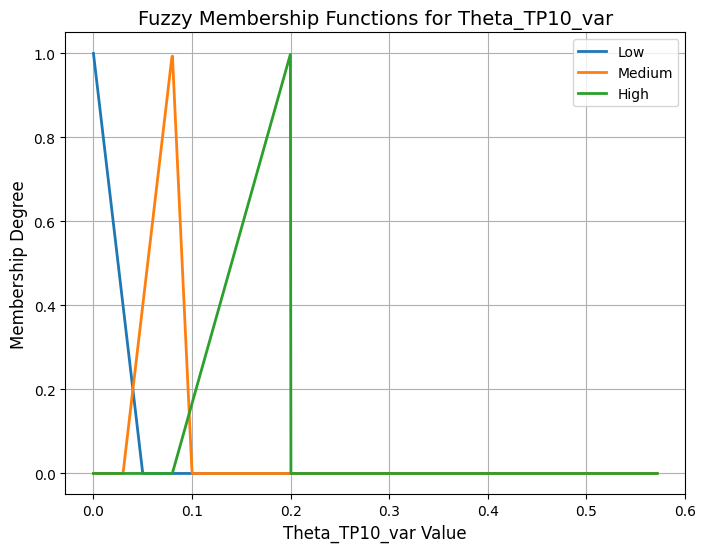

In [10]:
# Apply to the next feature "Theta_TP10_var"
feature_name = "Theta_TP10_var"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Theta_TP10_var to analyze
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='cyan', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


# Define fuzzy points for Theta_TP10_var based on observed distribution
theta_tp10_var_fuzzy_points = {
    "low": [0.0, 0.0, 0.05],  # Emphasize the cluster near 0.0
    "medium": [0.03, 0.08, 0.1],  # Cover the transition range
    "high": [0.08, 0.2, 0.2]  # Focus on the sparse upper range
}

# Visualize the membership functions with the defined fuzzy points
create_membership_functions(feature_name, feature_data, fuzzy_points=theta_tp10_var_fuzzy_points)


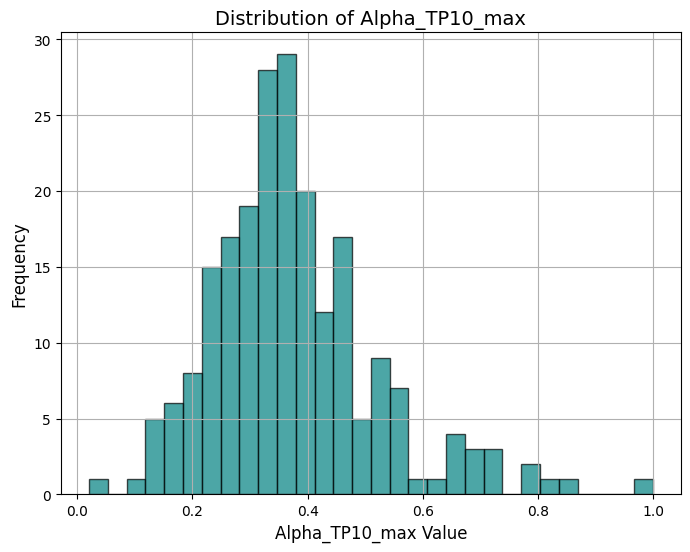

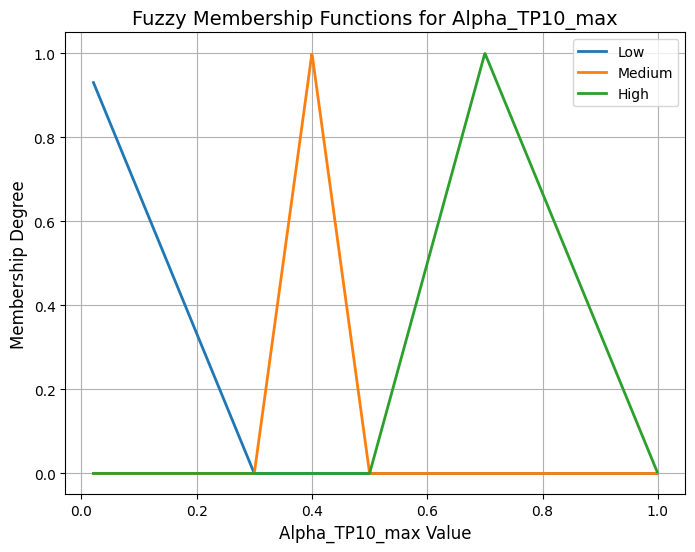

In [11]:
# Apply to the next feature "Alpha_TP10_max"
feature_name = "Alpha_TP10_max"
feature_data = X_train_resampled[feature_name]

# Step 1: Plot the distribution of Alpha_TP10_max
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='teal', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Adjust fuzzy points for Alpha_TP10_max based on observed distribution
alpha_tp10_max_fuzzy_points = {
    "low": [0.0, 0.0, 0.3],  # Cover the lower values up to the rising edge
    "medium": [0.3, 0.4, 0.5],  # Focus on the dense central range
    "high": [0.5, 0.7, 1.0]  # Cover the sparse upper range
}

# Visualize the membership functions with the adjusted fuzzy points
create_membership_functions("Alpha_TP10_max", feature_data, fuzzy_points=alpha_tp10_max_fuzzy_points)


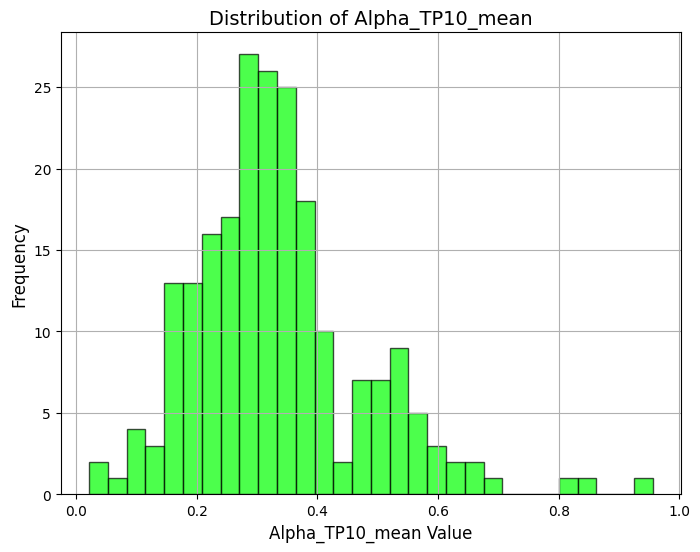

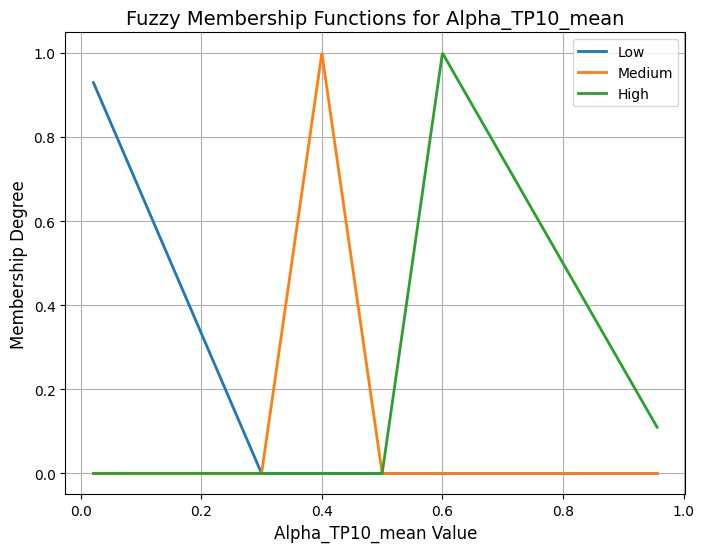

In [12]:
# Apply to the next feature "Alpha_TP10_mean"
feature_name = "Alpha_TP10_mean"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Alpha_TP10_mean to analyze
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='lime', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Adjust fuzzy points for Alpha_TP10_mean based on observed distribution
alpha_tp10_mean_fuzzy_points = {
    "low": [0.0, 0.0, 0.3],  # Focus on the sparse lower values
    "medium": [0.3, 0.4, 0.5],  # Capture the dense mid-range cluster
    "high": [0.5, 0.6, 1.0]  # Focus on the sparse upper range
}

# Visualize the membership functions with the adjusted fuzzy points
create_membership_functions("Alpha_TP10_mean", feature_data, fuzzy_points=alpha_tp10_mean_fuzzy_points)


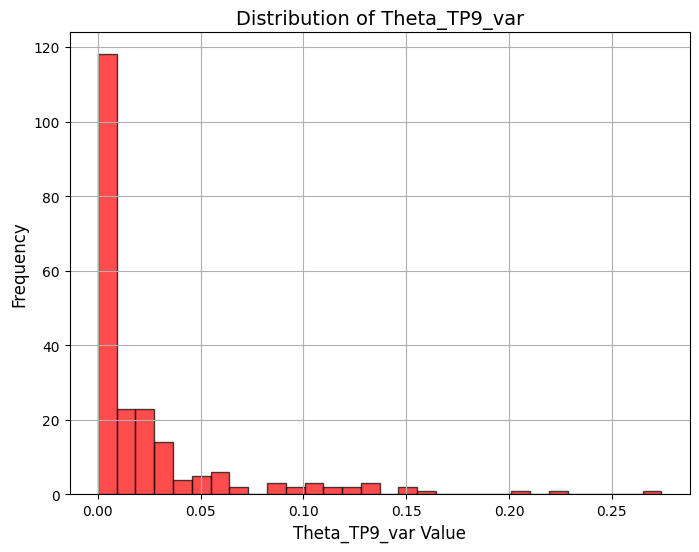

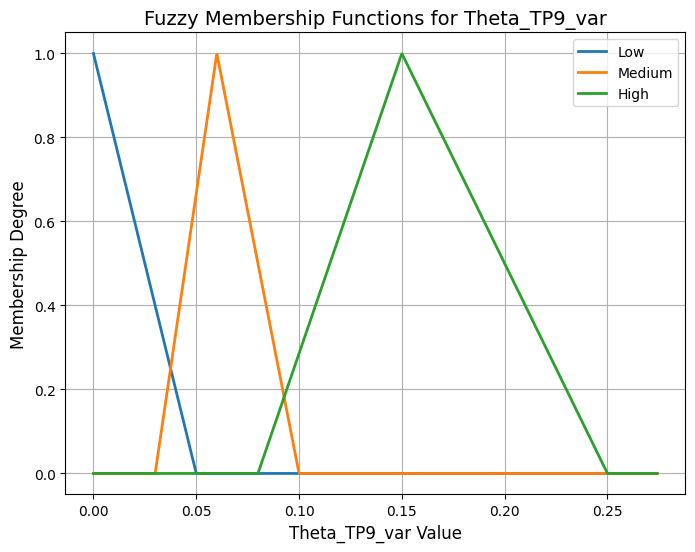

In [13]:
# Apply to the feature "Theta_TP9_var"
feature_name = "Theta_TP9_var"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Theta_TP9_var to analyze
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Adjust fuzzy points for Theta_TP9_var based on observed distribution
theta_tp9_var_fuzzy_points = {
    "low": [0.0, 0.0, 0.05],  # Emphasize the dense cluster near 0.0
    "medium": [0.03, 0.06, 0.1],  # Cover the transition range
    "high": [0.08, 0.15, 0.25]  # Focus on the sparse upper tail
}

# Visualize the membership functions with the adjusted fuzzy points
create_membership_functions("Theta_TP9_var", feature_data, fuzzy_points=theta_tp9_var_fuzzy_points)



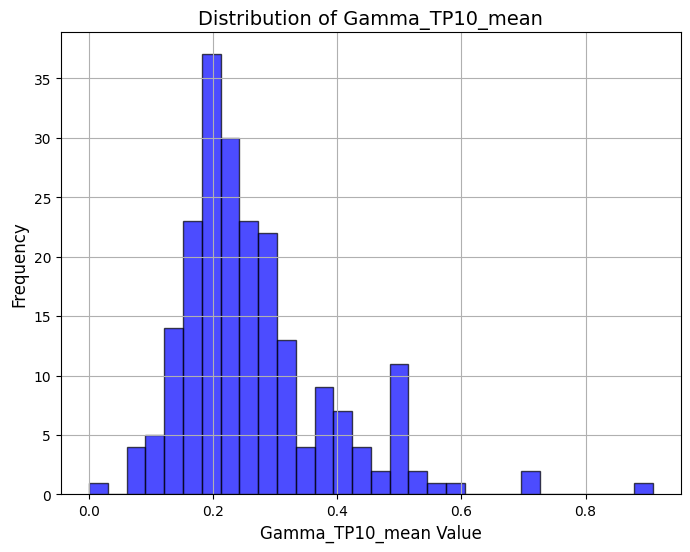

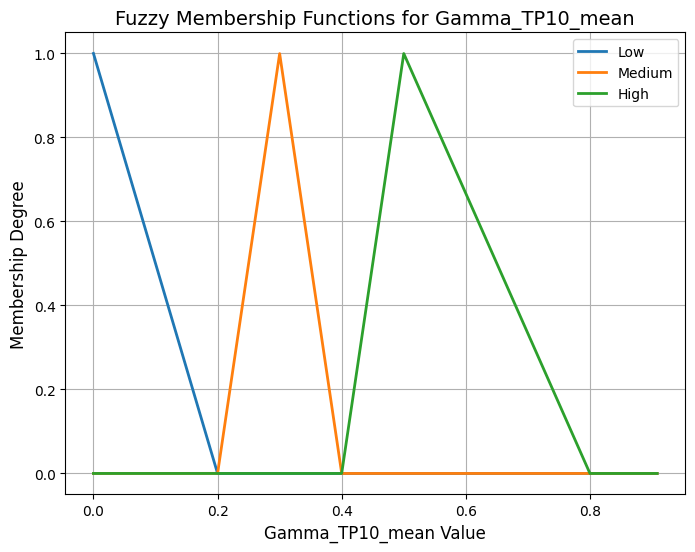

In [14]:
# Apply to the feature "Gamma_TP10_mean"
feature_name = "Gamma_TP10_mean"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Gamma_TP10_mean to analyze
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Adjust fuzzy points for Gamma_TP10_mean based on observed distribution
gamma_tp10_mean_fuzzy_points = {
    "low": [0.0, 0.0, 0.2],  # Cover the lower range up to the peak
    "medium": [0.2, 0.3, 0.4],  # Focus on the dense central range
    "high": [0.4, 0.5, 0.8]  # Cover the sparse upper range
}

# Visualize the membership functions with the adjusted fuzzy points
create_membership_functions("Gamma_TP10_mean", feature_data, fuzzy_points=gamma_tp10_mean_fuzzy_points)


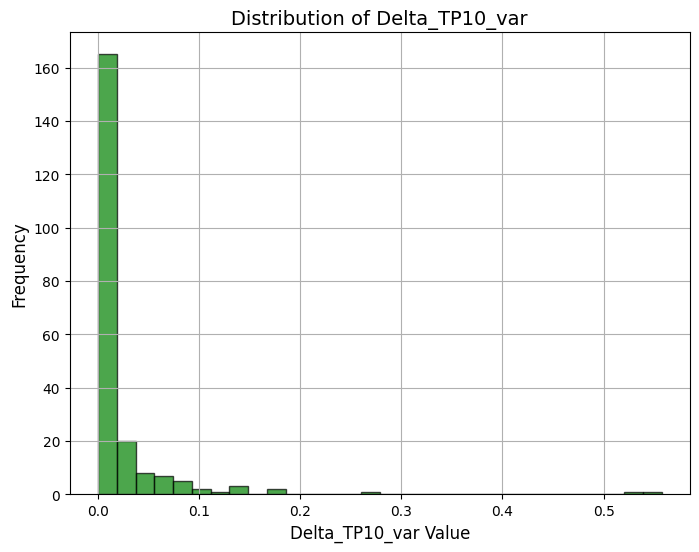

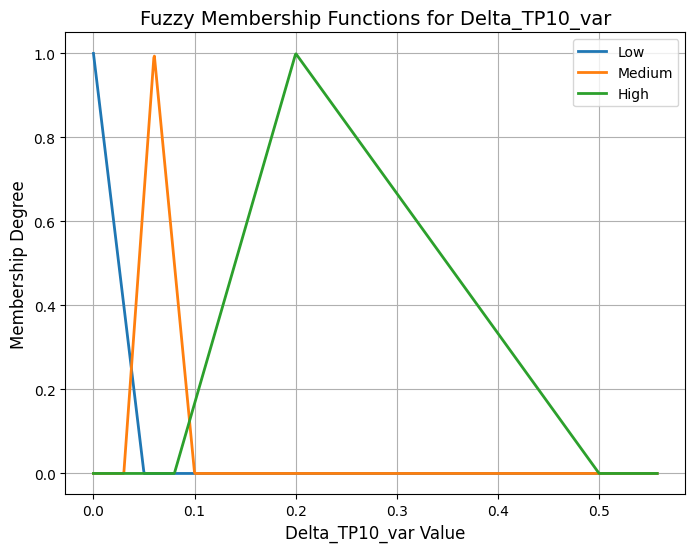

In [15]:
# Apply to the feature "Delta_TP10_var"
feature_name = "Delta_TP10_var"
feature_data = X_train_resampled[feature_name]

# Plotting the distribution of Delta_TP10_var to analyze
plt.figure(figsize=(8, 6))
plt.hist(feature_data, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title(f"Distribution of {feature_name}", fontsize=14)
plt.xlabel(f"{feature_name} Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

# Adjust fuzzy points for Delta_TP10_var based on observed distribution
delta_tp10_var_fuzzy_points = {
    "low": [0.0, 0.0, 0.05],  # Capture the dense lower cluster
    "medium": [0.03, 0.06, 0.1],  # Capture the transition zone
    "high": [0.08, 0.2, 0.5]  # Focus on the sparse upper range
}

# Visualize the membership functions with the adjusted fuzzy points
create_membership_functions("Delta_TP10_var", feature_data, fuzzy_points=delta_tp10_var_fuzzy_points)


In [ ]:

# Define a function to fuzzify a feature using skfuzzy's trimf
def fuzzify_feature_sklearn(feature_data, fuzzy_points, feature_name):
    """
    Fuzzify a feature using skfuzzy's trimf function.
    
    Args:
    feature_data (pd.Series): The feature data to fuzzify.
    fuzzy_points (dict): Dictionary containing points for 'low', 'medium', and 'high' sets.
    feature_name (str): Name of the feature.
    
    Returns:
    pd.DataFrame: DataFrame with membership degrees for the feature.
    """
    # Generate membership degrees using skfuzzy.trimf
    low_membership = fuzz.trimf(feature_data.values, fuzzy_points["low"])
    medium_membership = fuzz.trimf(feature_data.values, fuzzy_points["medium"])
    high_membership = fuzz.trimf(feature_data.values, fuzzy_points["high"])
    
    # Create a DataFrame for the fuzzified feature
    fuzzified_data = pd.DataFrame({
        f"{feature_name}_low": low_membership,
        f"{feature_name}_medium": medium_membership,
        f"{feature_name}_high": high_membership
    })
    
    return fuzzified_data

# Updated list of top 10 features with their fuzzy points 
fuzzy_features = [
    ("Gamma_AF7_var", gamma_af7_var_fuzzy_points),
    ("Alpha_TP10_max", alpha_tp10_max_fuzzy_points),
    ("Gamma_AF8_min", gamma_af8_min_fuzzy_points),
    ("Theta_TP9_var", theta_tp9_var_fuzzy_points),
    ("Alpha_AF8_var", alpha_tp10_mean_fuzzy_points),  
    ("Gamma_TP10_max", gamma_tp10_mean_fuzzy_points), 
    ("Gamma_TP10_mean", gamma_tp10_mean_fuzzy_points),
    ("Delta_TP10_var", delta_tp10_var_fuzzy_points),
    ("Alpha_TP10_mean", alpha_tp10_mean_fuzzy_points),
    ("Theta_TP10_var", theta_tp9_var_fuzzy_points)   
]

# Initialize a DataFrame for storing fuzzified data
fuzzified_dataset = pd.DataFrame()

# Iterate through each feature and apply fuzzification
for feature_name, fuzzy_points in fuzzy_features:
    if feature_name in X_test_resampled.columns:
        fuzzified_data = fuzzify_feature_sklearn(X_train_resampled[feature_name], fuzzy_points, feature_name)
        fuzzified_dataset = pd.concat([fuzzified_dataset, fuzzified_data], axis=1)
    else:
        print(f"Feature {feature_name} is missing in the dataset.")


# Save the fuzzified dataset for inspection
# fuzzified_dataset.to_csv("fuzzified_dataset_top10.csv", index=False)
fuzzified_dataset


,Gamma_AF7_var_low,Gamma_AF7_var_medium,Gamma_AF7_var_high,Alpha_TP10_max_low,Alpha_TP10_max_medium,Alpha_TP10_max_high,Gamma_AF8_min_low,Gamma_AF8_min_medium,Gamma_AF8_min_high,Theta_TP9_var_low,...,Gamma_TP10_mean_high,Delta_TP10_var_low,Delta_TP10_var_medium,Delta_TP10_var_high,Alpha_TP10_mean_low,Alpha_TP10_mean_medium,Alpha_TP10_mean_high,Theta_TP10_var_low,Theta_TP10_var_medium,Theta_TP10_var_high
0,0.945382,0.000000,0.000000,0.000000,0.526884,0.0,0.000000,0.982069,0.0,0.559147,...,0.000000,0.180700,0.365501,0.0,0.000000,0.353124,0.0,0.000000,0.146885,0.20178
1,0.000000,0.108824,0.156471,0.111873,0.000000,0.0,0.000000,0.505384,0.0,1.000000,...,0.000000,0.966059,0.000000,0.0,0.317104,0.000000,0.0,0.998910,0.000000,0.00000
2,0.953314,0.000000,0.000000,0.000000,0.633690,0.0,0.000000,0.722572,0.0,0.691872,...,0.000000,0.965974,0.000000,0.0,0.000000,0.684232,0.0,0.000000,0.000000,0.71130
3,0.974816,0.000000,0.000000,0.004333,0.000000,0.0,0.000000,0.925791,0.0,1.000000,...,0.000000,1.000000,0.000000,0.0,0.000000,0.006200,0.0,1.000000,0.000000,0.00000
4,0.874108,0.000000,0.000000,0.000000,0.237593,0.0,0.000000,0.000000,0.0,0.866675,...,0.467288,1.000000,0.000000,0.0,0.000000,0.206982,0.0,1.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.935565,0.000000,0.000000,0.000000,0.279630,0.0,0.000000,0.815278,0.0,0.731215,...,0.000000,0.959320,0.000000,0.0,0.041846,0.000000,0.0,0.738829,0.000000,0.00000
212,0.973411,0.000000,0.000000,0.000000,0.739742,0.0,0.360386,0.139614,0.0,0.882181,...,0.000000,0.462828,0.000000,0.0,0.000000,0.437971,0.0,0.582103,0.000000,0.00000
213,0.997990,0.000000,0.000000,0.000000,0.160125,0.0,0.255901,0.244099,0.0,0.998885,...,0.000000,0.984437,0.000000,0.0,0.016892,0.000000,0.0,0.999842,0.000000,0.00000
214,0.518902,0.000000,0.000000,0.396139,0.000000,0.0,0.000000,0.686703,0.0,1.000000,...,0.000000,1.000000,0.000000,0.0,0.392258,0.000000,0.0,1.000000,0.000000,0.00000


## Step 3: Integration with Classifier


In [62]:
# Merge fuzzified features with original dataset
merged_dataset = pd.concat([X_train_resampled.reset_index(drop=True), fuzzified_dataset.reset_index(drop=True)], axis=1)
print(f"Merged dataset shape: {merged_dataset.shape}")

# List of the original 10 selected features
original_features = [
    "Gamma_AF7_var",
    "Alpha_TP10_max",
    "Gamma_AF8_min",
    "Theta_TP9_var",
    "Alpha_AF8_var",
    "Gamma_TP10_max",
    "Gamma_TP10_mean",
    "Delta_TP10_var",
    "Alpha_TP10_mean",
    "Theta_TP10_var"
]

# Drop the original columns from the merged dataset
merged_dataset_updated = merged_dataset.drop(columns=original_features, errors='ignore')

# Verify the shape of the updated dataset
print(f"Shape of the merged dataset after dropping original features: {merged_dataset_updated.shape}")


Merged dataset shape: (216, 110)
Shape of the merged dataset after dropping original features: (216, 100)


### Classify the original dataset

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions and evaluate
y_pred = clf.predict(X_test_resampled)
print("Classification Report for the original Features:")
print(classification_report(y_test_resampled, y_pred))


Classification Report for the original Features:
              precision    recall  f1-score   support

       Blink       0.50      0.54      0.52        13
        Left       0.29      0.31      0.30        13
       Relax       0.36      0.38      0.37        13
       Right       0.30      0.23      0.26        13

    accuracy                           0.37        52
   macro avg       0.36      0.37      0.36        52
weighted avg       0.36      0.37      0.36        52



In [64]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train_resampled)

# Encode target labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train_resampled)

# Split into train and test sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Build a neural network
model_orig = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_orig.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for classification
])

# Compile the model
model_orig.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_orig = model_orig.fit(X_train_orig, y_train_orig, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


# Evaluate the NN model
loss_orig, accuracy_orig = model_orig.evaluate(X_test_orig, y_test_orig)
nn_predictions = model_orig.predict(X_test_orig)
y_pred_orig = nn_predictions.argmax(axis=1)



Epoch 1/100
5/5 [==============================] - 2s 50ms/step - loss: 1.3885 - accuracy: 0.2628 - val_loss: 1.3986 - val_accuracy: 0.2286
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 1.3737 - accuracy: 0.2993 - val_loss: 1.4131 - val_accuracy: 0.2000
Epoch 3/100
5/5 [==============================] - 0s 11ms/step - loss: 1.3579 - accuracy: 0.3212 - val_loss: 1.4115 - val_accuracy: 0.2000
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 1.3542 - accuracy: 0.3431 - val_loss: 1.4151 - val_accuracy: 0.2286
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 1.3466 - accuracy: 0.3504 - val_loss: 1.4144 - val_accuracy: 0.2286
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 1.3381 - accuracy: 0.3869 - val_loss: 1.4115 - val_accuracy: 0.2286
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 1.3318 - accuracy: 0.4453 - val_loss: 1.4039 - val_accuracy: 0.2286
Epoch 8/100
5/5 [===

In [65]:
# Print NN Classification Report
nn_report = classification_report(y_test_orig, y_pred_orig)
print("\nNeural Network Classification Report:")
print(nn_report)


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.29      0.33         7
           1       0.27      0.30      0.29        10
           2       0.50      0.60      0.55        15
           3       0.20      0.17      0.18        12

    accuracy                           0.36        44
   macro avg       0.34      0.34      0.34        44
weighted avg       0.35      0.36      0.35        44



### Classify the fuzzified dataset

In [66]:
# Use fuzzified dataset as features (X) and the target variable (y)
y = y_train_resampled.reset_index(drop=True)  # Ensure alignment with merged dataset
X = fuzzified_dataset

# Split into train and test sets
X_train_fuzzy, X_test_fuzzy, y_train_fuzzy, y_test_fuzzy = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_fuzzy, y_train_fuzzy)

# Make predictions and evaluate
y_pred_fuzzy = clf.predict(X_test_fuzzy)
print("Classification Report for Fuzzified Features:")
print(classification_report(y_test_fuzzy, y_pred_fuzzy))


Classification Report for Fuzzified Features:
              precision    recall  f1-score   support

       Blink       0.45      0.71      0.56         7
        Left       0.29      0.40      0.33        10
       Relax       0.38      0.20      0.26        15
       Right       0.18      0.17      0.17        12

    accuracy                           0.32        44
   macro avg       0.32      0.37      0.33        44
weighted avg       0.31      0.32      0.30        44



In [67]:
# Normalize fuzzified features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(fuzzified_dataset)

# Split scaled data
X_train_fuzzy_nn, X_test_fuzzy_nn, y_train_fuzzy_nn, y_test_fuzzy_nn = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ensure that the input features are numerical
X_train_fuzzy_nn = X_train_fuzzy_nn.astype(float)
X_test_fuzzy_nn = X_test_fuzzy_nn.astype(float)

label_encoder = LabelEncoder()
y_train_fuzzy_nn = label_encoder.fit_transform(y_train_fuzzy_nn)
y_test_fuzzy_nn = label_encoder.transform(y_test_fuzzy_nn)

# Build a neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_fuzzy_nn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(y.unique()), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_fuzzy_nn, y_train_fuzzy_nn, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the NN model
loss, accuracy = model.evaluate(X_test_fuzzy_nn, y_test_fuzzy_nn)
nn_predictions = model.predict(X_test_fuzzy_nn)
y_pred_fuzzy_nn = nn_predictions.argmax(axis=1)


Epoch 1/100
5/5 [==============================] - 1s 66ms/step - loss: 1.4225 - accuracy: 0.1971 - val_loss: 1.4091 - val_accuracy: 0.2571
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 1.3943 - accuracy: 0.2482 - val_loss: 1.4009 - val_accuracy: 0.2857
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3779 - accuracy: 0.2993 - val_loss: 1.3987 - val_accuracy: 0.2286
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 1.3627 - accuracy: 0.3869 - val_loss: 1.3984 - val_accuracy: 0.1714
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 1.3527 - accuracy: 0.4088 - val_loss: 1.3997 - val_accuracy: 0.2286
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 1.3412 - accuracy: 0.3869 - val_loss: 1.3994 - val_accuracy: 0.2286
Epoch 7/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3308 - accuracy: 0.4161 - val_loss: 1.3981 - val_accuracy: 0.1714
Epoch 8/100
5/5 [===

In [59]:
# Print NN Classification Report
nn_report = classification_report(y_test_fuzzy_nn, y_pred_fuzzy_nn)
print("\nNeural Network Classification Report:")
print(nn_report)


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.43      0.33         7
           1       0.17      0.10      0.12        10
           2       0.60      0.40      0.48        15
           3       0.29      0.42      0.34        12

    accuracy                           0.34        44
   macro avg       0.33      0.34      0.32        44
weighted avg       0.37      0.34      0.34        44



### Classify the merged dataset

In [74]:
# Prepare target variable and merged dataset
y = y_train_resampled.reset_index(drop=True)
X = merged_dataset_updated

# Split the merged dataset into train and test sets for both classifiers
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Train the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_merged, y_train_merged)

# Make predictions and evaluate
y_pred_rf = rf_clf.predict(X_test_merged)
rf_report = classification_report(y_test_merged, y_pred_rf)
print("Random Forest Classification Report:")
print(rf_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

       Blink       0.08      0.14      0.10         7
        Left       0.12      0.20      0.15        10
       Relax       0.57      0.27      0.36        15
       Right       0.14      0.08      0.11        12

    accuracy                           0.18        44
   macro avg       0.23      0.17      0.18        44
weighted avg       0.27      0.18      0.20        44



In [75]:
# Normalize the merged dataset for Neural Network
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode target labels to integers for TensorFlow
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split scaled dataset
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Build a neural network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for classification
])

# Compile the NN model
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the NN model
history_nn = nn_model.fit(X_train_nn, y_train_nn, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the NN model
loss_nn, accuracy_nn = nn_model.evaluate(X_test_nn, y_test_nn)
nn_predictions = nn_model.predict(X_test_nn)
y_pred_nn = nn_predictions.argmax(axis=1)


Epoch 1/100
5/5 [==============================] - 1s 58ms/step - loss: 1.4029 - accuracy: 0.2044 - val_loss: 1.3925 - val_accuracy: 0.2857
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 1.3773 - accuracy: 0.2993 - val_loss: 1.3921 - val_accuracy: 0.2857
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 1.3652 - accuracy: 0.3212 - val_loss: 1.3921 - val_accuracy: 0.2571
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 1.3538 - accuracy: 0.3358 - val_loss: 1.3970 - val_accuracy: 0.2286
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 1.3453 - accuracy: 0.3358 - val_loss: 1.3987 - val_accuracy: 0.2286
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 1.3352 - accuracy: 0.3431 - val_loss: 1.3940 - val_accuracy: 0.2286
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 1.3272 - accuracy: 0.3577 - val_loss: 1.3943 - val_accuracy: 0.2857
Epoch 8/100
5/5 [===

In [76]:
# Print NN Classification Report
nn_report = classification_report(y_test_nn, y_pred_nn)
print("\nNeural Network Classification Report:")
print(nn_report)


Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.57      0.47         7
           1       0.20      0.20      0.20        10
           2       0.55      0.40      0.46        15
           3       0.23      0.25      0.24        12

    accuracy                           0.34        44
   macro avg       0.34      0.36      0.34        44
weighted avg       0.36      0.34      0.34        44

